# A Tiny Spiking Neural Network on Dynap-SE1 Simulator

By [Yigit Demirag](https://www.ini.uzh.ch/fw1/modules/ini/ini.php/people/yigit)

In this exercise we will learn and simulate the silicon neuron and synapse models of a neuromorphic processor, DYNAP-SE1. Specifically, we will first show how a simple Differential Pair Integrator (DPI) circuit is used in Dynap-SE1 to implement some fundamental dynamics of silicon synapse and Adaptive Exponential Integrate-and-Fire (AdExpIF) neurons. Then we will learn how we set up neuron and synapse parameters, form networks, and monitor the electrical signals at various stages in the chip. Finally, we will observe the adaptive behavior of the neuron.


## Part 1: I/O Spikes
---

#### Differential Pair Integrator (DPI)

The computational principles of the brain are vastly different from conventional computers. Rather than using Boolean logic, clocked operation, and distinct memory and processing units, the biological brain works at massively parallel, fault-tolerant, asynchronous manner. In neuromorphic engineering, we aim to design compact, energy-efficient computational devices that directly _emulate_ the style of computation of the brain with **the physics of the silicon.** To achieve that, we use analog Complementary Metal-Oxide-Semiconductor (CMOS) technology to implement neural and synaptic circuits and integrate into Very Large Scale Integration (VLSI) devices. In these architectures, time represents itself (no clock) - neurons process the incoming spikes as they arrive and produce output spikes in real-time. Consequently, to process real-world sensory signals efficiently, neuromorphic systems must use circuits with biologically plausible time constants that match environment statistics ($\sim 10-100$ ms). 

<img src="img/DPI_advanced.png" alt="DPI circuit." style="width: 450px;">

DPI circuit shown above is the fundamental building block to implement silicon neurons and synapses with tunable time-constants. It is totally fine if you do not understand how it works from the circuit diagram right away. The essence is that it has the response dynamics (the relation of input current $I_{i n}$ and output current $I_{out}$) of

$$\tau \frac{d}{d t} I_{o u t}+I_{o u t}=\frac{I_{g}}{I_{\tau}} I_{i n},$$

where $\tau \triangleq C U_{T} / \kappa I_{\tau}$ ($C$ the capacitor, $U_T$ thermal voltage, $\kappa$ subthreshold slope factor). DPI circuit can be tuned by adjusting the time constant, $I_{\tau}$, and the gain factor by $I_{g}$. Hence DPI is simply a current-mode low pass filter with adjustable gain and time-constant. This will be the building block of silicon neurons and synapses.

#### Silicon Neuron

<img src="img/neuron.png" alt="Neuron circuit." style="width: 400px;">

The above schematic shows the neuron circuit implementing Adaptive Exponential Integrate & Fire (AdEx) on Dynap-SE1. AdEx neurons are introduced by [Brette and Gerstner, 2005](https://www.readcube.com/library/a457847f-fdff-4d66-a32a-b3830a010b34:72216f6a-1527-440d-b775-be66fa7085a1) that capable of describing known neuronal firing patterns, e.g., adapting, bursting, delayed spike initiation, initial bursting, fast-spiking, and regular spiking. We will not go into detail of circuit analysis but describe the functional blocks. The yellow block is the input DPI circuit modeling neuron's leak conductance. The green block implements an additional low-pass ﬁlter that integrates the spikes and produces a slow current $I_{ahp}$ responsible for spike-frequency adaptation. The red block is a spike event generation amplifier implementing current-based positive feedback (modeling both $Na^{+}$ activation and inactivation conductances) and produces address-events at extremely low-power operation. Lastly, the blue block resets the neuron and keeps it in a resting state for a refractory period, set by the $V_{ref}$ bias voltage. Under some assumptions, the response dynamics of neuron block is:

$$\tau \frac{d}{d t} I_{m e m}+I_{m e m} \approx I_{i n}-I_{a h p}+f\left(I_{m e m}\right)$$
$$\tau_{a h p} \frac{d}{d t} I_{a h p}+I_{a h p} \approx I_{a h p} \delta\left(t_{s p i k e}\right)$$


Here, $I_{m e m}$ is the sub-threshold current that represents the real neuron's membrane potential variable, $I_{i n}$ is the input current that enters the neuron, $I_{a h p}$ characterizes the spike adaptation effect, $\tau$ is the time-constant of leakage current. $f(x)$ is an exponential function with positive exponent which characterizes the passive properties, i.e. $f(x) = \alpha e^{ \beta x - \gamma} + \delta$.

#### Silicon Synapse


<img src="img/synapse.png" alt="Synapse circuit." style="width: 400px;">

Lastly, the above schematic shows a typical silicon synapse circuit implemented on Dynap-SE1. The green block implements short-term depression (STD). The yellow block implements basic DPI dynamics and can be tuned to implement short-term facilitation (STF). The red block implements NMDA voltage-gated channels, and the blue block implements conductance-based voltage dependence. The simplified version of the response dynamics of the synaptic block is:

$$\tau \frac{d}{d t} I_{s y n}(t)+I_{s y n}(t)=I_{w} \delta\left(t_{p r e}\right)$$
where $I_{s y n}$ is the synaptic current, $I_{w}$ is the gain factor (weight) of the synapse, and $\tau$ is time constant of current decay.

For more detailed explanations of neural and synaptic circuits (and especially the derivations and the assumptions behind the formulas mentioned) you can check [PDF available on arXiv.](https://arxiv.org/pdf/1403.6428.pdf)

>Chicca, E., Stefanini, F., Bartolozzi, C., Indiveri, G. (2014). Neuromorphic Electronic Circuits for Building Autonomous Cognitive Systems Proceedings of the IEEE  102(9), 1367-1388.

### Setting up the network

We will use [Brian2](https://brian2.readthedocs.io/en/stable/) to implement our spiking neural network. There are other options available (NEST, PyTorch, etc.), but Brian2 is both fast and flexible when working with spikes. More importantly, our group has already modeled the neural and synaptic circuits that Dynap-SE1 uses on Brian2. Therefore as we will execute spiking neural networks on Brian2, we will be simulating the circuits of Dynap-SE1. Super cool :)

So, let's start with importing Brian2.

In [1]:
from brian2 import *

Brian2 allows us to write models for neuron and synapses,  create large populations of neurons, and connect them arbitrarily. On the other hand, the real chip has predefined resources, and circuits are fixed. There is no time-multiplexing of resources. Hence for this session, we created a simple `DynapSE.py` wrapper class that implements DPI neuron and synaptic circuit models and  monitors chip resources (e.g., number of available neurons per core, number of synapses between neurons, etc.)

In [2]:
import sys 
sys.path.append('..')

from DynapSE import DynapSE

We then import dynamical array processing (Numpy) and plotting (Matplotlib) libraries.

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90  

The ordinary differential equations defining neuron and synapse models should be accessible by Brian2. Let's import the model equations and their parameters.

In [4]:
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

### Generating Input Spike Pattern

The language of neuromorphic chips is spike trains. Whether we want to process the analog or digital signal, we need to convert it to spikes first. Inside Dynap-SE1, we have such converters, following a single protocol: AER (Address-Event Representation). AER uses (spike source address, timing) pair to define a single spike. In this exercise, we will not use AER but the Dirac delta function $\rho(t)=\sum_{i=1}^{k} \delta\left(t-t_{i}\right)$ to define spike trains. 

In the cell below, you will see three different spike train implementations 
`regular`, `poisson`, and `cosine`. You can change the variables in the TODO section (optional) and customize your input pattern.

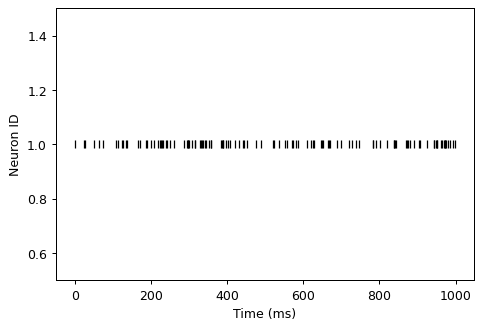

In [5]:
# Input Generator
##################
# TODO: 
# - Play with different input spike patterns by changing input_type (optional).
#
# Parameters
input_type   = 'poisson' # 'regular', 'poisson' or 'cosine' (Default: poisson)
pulse_start  = 0         # second - Start time of input (Default: 0)
pulse_stop   = 1         # second - Stop time of input (Default: 5)
inp_duration = 1         # second - Simulation duration (Default: 5)
rate         = 100       # Hz or rad/sec - Spiking rate (Default: 80 Hz for regular, 100 Hz for poission, 2 rad/sec for cosine) 
##################

if input_type == 'regular':
    
    spikes = np.zeros(inp_duration*1000)
    dt = int(1000/rate)
    spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0

if input_type == 'poisson':

    prob = rate * 1e-3
    mask = np.random.rand(inp_duration*1000)
    spikes = np.zeros(inp_duration*1000)
    spikes[mask < prob] = 1.0
    spikes[:pulse_start*1000]=0
    spikes[pulse_stop*1000:]=0

if input_type == 'cosine':
    
    spikes = np.zeros(inp_duration*1000)
    time = np.linspace(0, inp_duration, inp_duration*1000)
    co = np.cos(2 * np.pi * rate * time)
    mask = 20 * np.random.rand(inp_duration*1000)
    spikes[mask < co] = 1.0
    spikes[:pulse_start*1000]=0
    spikes[pulse_stop*1000:]=0

plt.plot(spikes,'k|')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron ID")
plt.ylim(0.5, 1.5)
plt.show()

Now that we have an input spike pattern, we need to tell Brian2 to use the spikes we just generated. To do that, we define two arrays specifying spike indices (ID of spike source) and the spike timing. The sizes of two arrays match since Brian2 will check both and assign spike timings to spike sources. We will have single source ID because we generated only one spike pattern.

In [6]:
# Reinitialize the device
device.reinit()
device.activate()
defaultclock.dt = 20 * us

spike_timing = np.where(spikes==1)[0] * ms # Timing of spikes
neuron_indices = np.zeros(len(spike_timing)) # ID of spike sources
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')    

### Creating a Network 

To create a spiking neural network on Brian2, there are three pillars we need to understand. Brian2 requires the `Network()` instance, which handles the running of the simulation.  It contains a set of Brian objects (e.g., neurons, synapses, monitors, etc.) added with `add()` function. The final `run()` method runs the simulation. 

After creating a `network` instance, we will pass it to the `DynapSE()` method to create a  new `chip` instance. Creating a spiking neural network and passing it to a neuromorphic chip class may seem peculiar. However, this will allow us to make sure that the chip can support the Brian2 network.


In [7]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics


Now let's look at the inside of the Dynap-SE1 chip. Inside, there are four event-based, mixed-signal neuromorphic cores; each one has 256 DPI neurons. Each neuron is identical to the others by design; however, it may have slightly different parameters due to the noise and mismatch in analog circuits. In the simulation, you can allocate `num_n` neurons from a core `X` by using `get_neurons(num_n, 'Core_X')` method, which returns a [SubGroup](https://brian2.readthedocs.io/en/stable/reference/brian2.groups.subgroup.Subgroup.html) of DPI neurons.

An individual neuron can have a fan-in of 64 and a fan-out of 4k connections. Users can determine the types of the synapses to exhibit one of 4 different behaviors: fast excitatory (AMPA), slow excitatory (NMDA), subtractive inhibitory (GABA_B), or shunting inhibitory (GABA_A, a mixture of subtractive and divisive).  User can connect different neurons (which are obtained with `get_neurons()`) to each other using `add_connection(pre_population, post_population, synapse_type)` method. Synapse type can be either `AMPA`, `NMDA`, `GABA_A` and `GABA_B`.


Now, let's allocate a single neuron from the first core of Dynap-SE1, then define NMDA- and AMPA- type synaptic connections to our custom `input_spike_generator`.

In [8]:
DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1
DPI_NMDA_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='NMDA') # Define a slow excitatory synapse
DPI_AMPA_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA') # Define a fast excitatory synapse

# In Brian2 creating Synapses instance does not connect two endpoints, it only specifies synaptic dynamics 
# Let's connect two endpoints and set an initial weight of 300.

chip.connect(DPI_NMDA_synapse, True)
DPI_NMDA_synapse.weight = 0.5

chip.connect(DPI_AMPA_synapse, True)
DPI_AMPA_synapse.weight = 2

1 neurons are allocated from Core_1.


Until now, we created a spike generator, allocated a neuron from the chip, and formed two synaptic connections (fast and slow) between. Before starting the simulation, we can add [monitors](https://brian2.readthedocs.io/en/stable/reference/brian2.monitors.html) 
for simulation variables that evolve during the simulation. This is one of the best parts of having a simulation of complex systems; we can monitor everything. What do we want to monitor?

- Spikes from input spike generator
- Output current of 1) fast excitatory 2) slow excitatory synapses 
- Neuron membrane current
- Output activity of DPI neuron 

PS: If you are curious about where `I_syn_nmda`, `I_syn_ampa` and `Imem` variables come from, you should check `dynapse_eq.py` where we define DPI dynamics of neurons and synapses.

In [9]:
# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'Inmda', record=[0])
mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'Iampa', record=[0])
mon_neuron_state  = StateMonitor(DPI_neuron, 'Isoma_mem', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator, DPI_neuron, DPI_NMDA_synapse, DPI_AMPA_synapse, mon_neuron_input, mon_synapse_nmda, mon_synapse_ampa, mon_neuron_output, mon_neuron_state])

Now, let's run the simulation for a predefined time. Depending on your computer's CPU, it may take a while (< 15 sec with 2015 MacBook Pro).

In [10]:
# Simulation
network.run(inp_duration * 1000 * ms)

After the simulation is completed, we can see how the variables that we monitored evolved. Let's plot input spikes, membrane voltage, and output spikes to understand the neuron's response. 

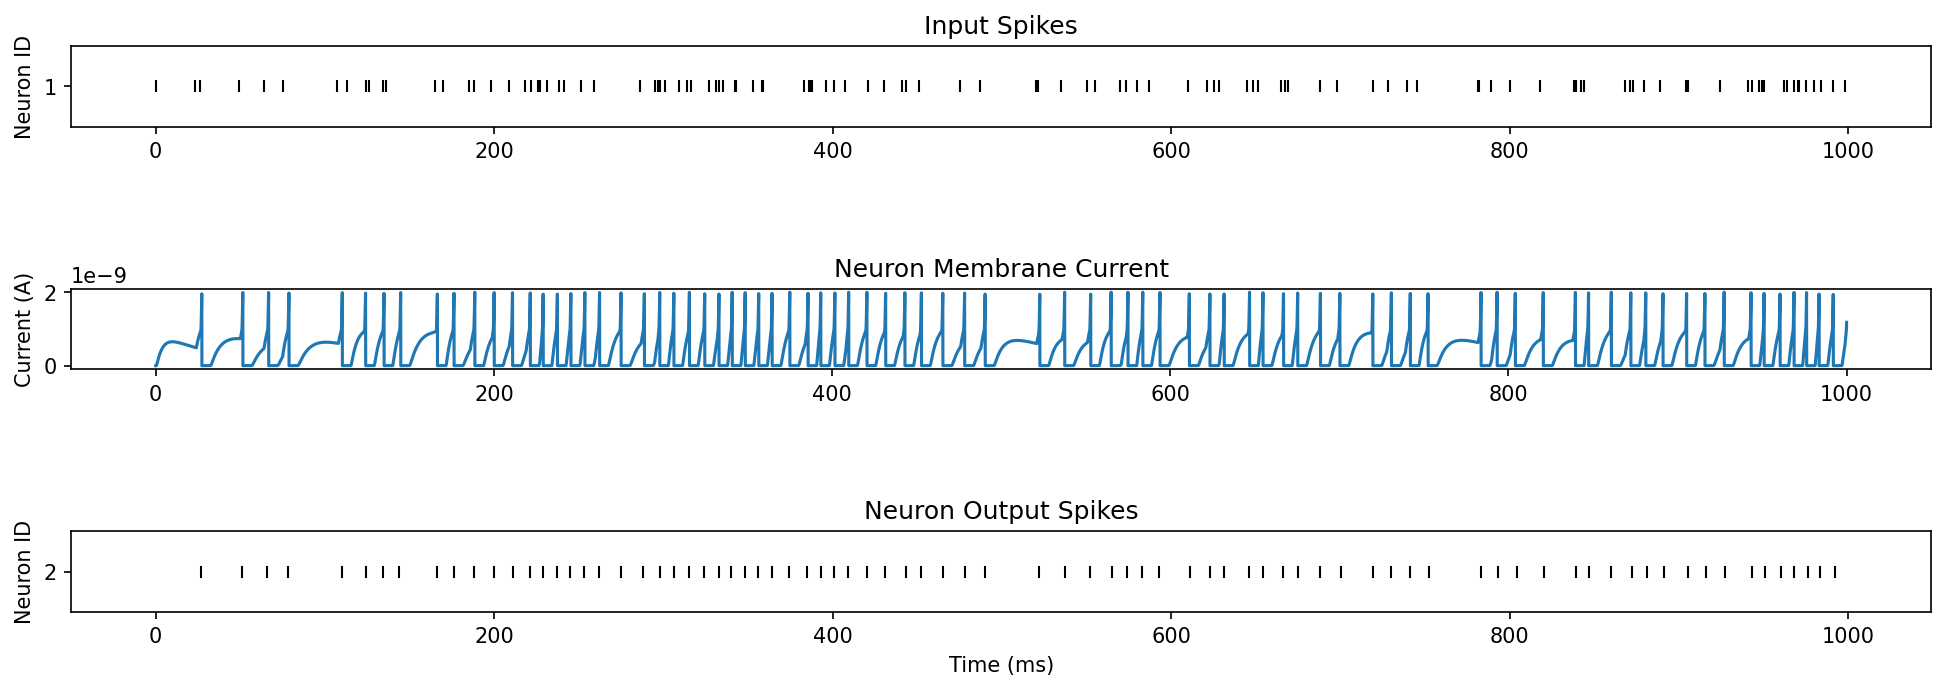

In [11]:
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

# Input Spikes 
plt.subplot(311)
spike_placeholder = np.zeros(inp_duration * 1000)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(312)
Isoma_mem = mon_neuron_state.Isoma_mem[0]
plt.plot(mon_neuron_state.t/ms, Isoma_mem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(313)
spike_placeholder = np.zeros(inp_duration * 1000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

We provided an input spike train to a DPI neuron then observed some output spikes (If input spike parameters are correct). Now, we monitor the output current of DPI synapse that enters to neuron.

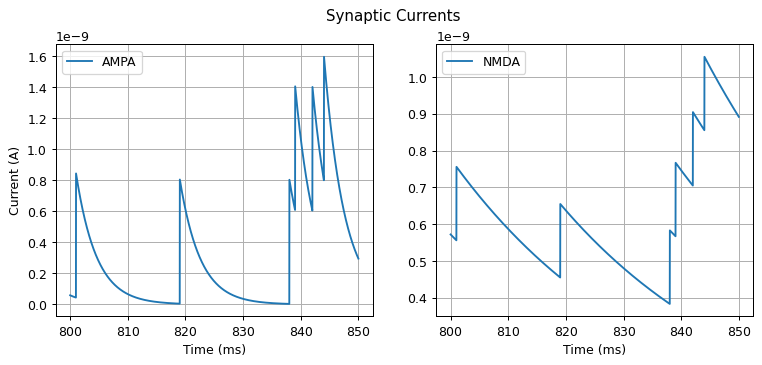

In [12]:
##################
#  TODO: Play with tstart and tend to locate synaptic currents. Try to estimate the time constant of the decay. 
#  Why do you think the amount of current at each input spike are not exactly same?
#
# Parameters
tstart = 800 # ms 
tend   = 850 # ms
##################

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))
fig.suptitle('Synaptic Currents')
s = int(1*ms / defaultclock.dt)

ax1.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.Iampa[0][tstart*s:tend*s], linewidth=1.5)
ax1.legend(['AMPA'])
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)
ax2.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_nmda.Inmda[0][tstart*s:tend*s], linewidth=1.5)
ax2.legend(['NMDA'])
ax2.set_xlabel('Time (ms)')
ax2.grid(True)

Finally, we can observe the membrane current ($I_{mem}$) on silicon neuron and see how synaptic input accumulates and results in spikes.

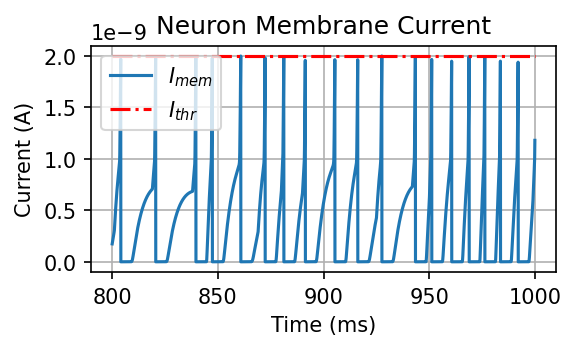

In [13]:
##################
#  TODO: Play with tstart and tend to observe membrane current fluctuations and the moments of spike output.
#        Notice that the membrane current is more smoother than its synaptic input.
#
# Parameters
tstart = 800 # ms  
tend   = 1000 # ms 
##################

# Plotting
s = int(1*ms / defaultclock.dt)
plt.figure(figsize=(4,2),dpi=150)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_neuron_state.Isoma_mem[0][tstart*s:tend*s], linewidth=1.5)
plt.hlines(y=dynapse_param['Isoma_th']*1e-9/nA, xmin=tstart, xmax=tend, color='r', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlabel('Time (ms)')
plt.grid(True)

This is the end of Part 1.